# **Importing Necessary Libraries**

In [1]:
import os
import cv2
import pandas as pd
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from skimage.filters import sobel
from skimage.segmentation import active_contour
from tqdm import tqdm

# **Training the Model**

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/35
539/539 ━━━━━━━━━━━━━━━━━━━━ 39s 68ms/step - accuracy: 0.1520 - loss: 3.8588 - val_accuracy: 0.7360 - val_loss: 1.1002
Epoch 2/35
539/539 ━━━━━━━━━━━━━━━━━━━━ 37s 70ms/step - accuracy: 0.5530 - loss: 1.7533 - val_accuracy: 0.8677 - val_loss: 0.7387
Epoch 3/35
539/539 ━━━━━━━━━━━━━━━━━━━━ 35s 65ms/step - accuracy: 0.6773 - loss: 1.3410 - val_accuracy: 0.8947 - val_loss: 0.6289
Epoch 4/35
539/539 ━━━━━━━━━━━━━━━━━━━━ 37s 68ms/step - accuracy: 0.7291 - loss: 1.1676 - val_accuracy: 0.9080 - val_loss: 0.6107
Epoch 5/35
539/539 ━━━━━━━━━━━━━━━━━━━━ 36s 67ms/step - accuracy: 0.7684 - loss: 1.0635 - val_accuracy: 0.9173 - val_loss: 0.5784
Epoch 6/35
539/539 ━━━━━━━━━━━━━━━━━━━━ 35s 64ms/step - accuracy: 0.7919 - loss: 0.9985 - val_accuracy: 0.9155 - val_loss: 0.5889
Epoch 7/35
539/539 ━━━━━━━━━━━━━━━━━━━━ 42s 67ms/step - accuracy: 0.8045 - loss: 0.9425 - val_accuracy: 0.9209 - val_loss: 0.5877
Epoch 8/35
539/539 ━━━━━━━━━━━━━━━━━━━━ 35s 65ms/step - accuracy: 0.8167 - loss: 0.9205 - 

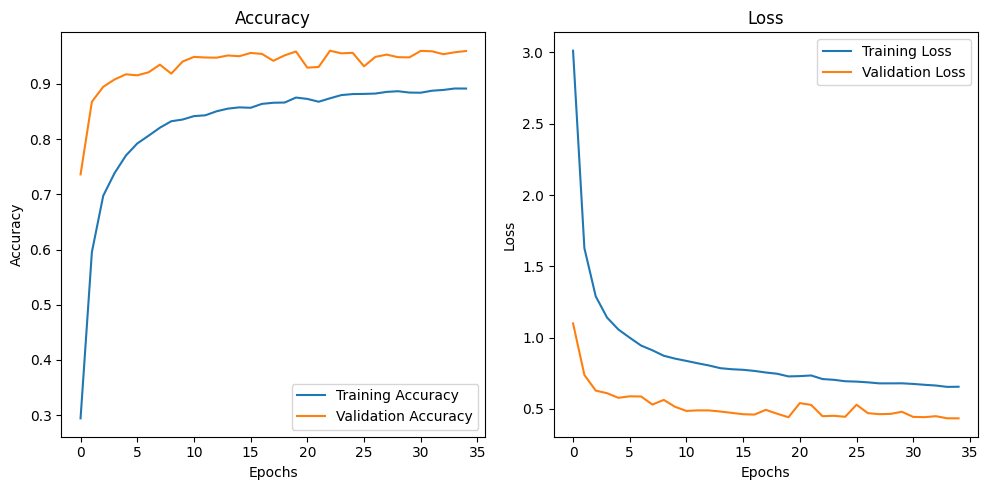

In [2]:
# Function to load data from a CSV file and apply transformations
def load_csv_data(file_path, img_size=(32, 32)):
    data = pd.read_csv(file_path)
    labels = data.iloc[:, 0].values  # First column contains labels
    images = data.iloc[:, 1:].values  # Remaining columns contain pixel values
    images = images.reshape(-1, img_size[0], img_size[1])  # Reshape to (num_samples, img_size[0], img_size[1])
    return images, labels

# Preprocessing function: normalize and standardize the dataset
def preprocess_images(images):
    img_size=(32,32)
    images = np.array([np.rot90(np.fliplr(img)) for img in images])
    #resized_images = np.array([cv2.resize(img, img_size, interpolation=cv2.INTER_AREA) for img in images])
    #images = images / 255.0  # Normalize to [0, 1]
    #mean = np.mean(images, axis=0)  # Calculate the mean for mean subtraction
    #std = np.std(images, axis=0) + 1e-7  # Avoid division by zero
    #images = (images - mean) / std  # Standardize images
    return images

# Load the data
train_csv = "/content/Handwritten_V2_train.csv"  # Replace with actual file path
val_csv = "/content/Handwritten_V2_valid.csv"  # Replace with actual file path

X_train, y_train = load_csv_data(train_csv)
X_val, y_val = load_csv_data(val_csv)

# Apply preprocessing
X_train = preprocess_images(X_train)
X_val = preprocess_images(X_val)

# Reshape for CNN input
X_train = X_train[..., np.newaxis]  # Add channel dimension
X_val = X_val[..., np.newaxis]

# Calculate the number of classes correctly
num_classes = np.max(y_train) + 1  # Add 1 because labels are zero-indexed

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False
)
datagen.fit(X_train)

# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1), kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_val, y_val),
                    epochs=35)

# Plot training and validation accuracy/loss
plt.figure(figsize=(10, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# **Saving the Model**

In [3]:
model.save('/content/malayalam_handwriting_model.h5')